In [486]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [487]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm
import lightgbm as lgb
import pickle
from scipy.stats import poisson

In [488]:
df = pd.read_csv("/content/drive/MyDrive/School/CSE 6242/df_states.csv")


df["sex"] = df["sex"].astype("category")
df["state"] = df["state"].astype("category")
df["UCD"] = df["UCD"].astype("category")

display(df)

,year,state,state_code,sex,age_code,UCD,deaths,population,obesity_pct,uninsured_pct,income_mean,employed_pct,diabetes_pct,educa_z,smoking_pct_z,binge_drink_pct_z,seatbelt_always_pct_z,rural_pct
0,1999,Alabama,1.0,F,1,#Malignant neoplasms (C00-C97),Suppressed,28712.0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
1,1999,Alabama,1.0,F,1,"#Diseases of heart (I00-I09,I11,I13,I20-I51)",Suppressed,28712.0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
2,1999,Alabama,1.0,F,1,#Cerebrovascular diseases (I60-I69),0,28712.0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
3,1999,Alabama,1.0,F,1,#Chronic lower respiratory diseases (J40-J47),0,28712.0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
4,1999,Alabama,1.0,F,1,"#Accidents (unintentional injuries) (V01-X59,Y...",Suppressed,28712.0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100975,2020,Wyoming,56.0,M,65-74,#Malignant neoplasms (C00-C97),188,32197.0,30.700000,18.535808,6.182715,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0
100976,2020,Wyoming,56.0,M,65-74,"#Diseases of heart (I00-I09,I11,I13,I20-I51)",186,32197.0,30.700000,18.535808,6.182715,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0
100977,2020,Wyoming,56.0,M,65-74,#Cerebrovascular diseases (I60-I69),21,32197.0,30.700000,18.535808,6.182715,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0
100978,2020,Wyoming,56.0,M,65-74,#Chronic lower respiratory diseases (J40-J47),64,32197.0,30.700000,18.535808,6.182715,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0


In [489]:
# We are summing YPLL over all age groups, so we need the summed population as well
pops = df[["year", "state", "sex", "age_code", "population"]].drop_duplicates()
pops = pops.groupby(["year", "state", "sex"])["population"].sum().reset_index()
pops

/tmp/ipython-input-1411095849.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pops = pops.groupby(["year", "state", "sex"])["population"].sum().reset_index()


,year,state,sex,population
0,1999,Alabama,F,2123086.0
1,1999,Alabama,M,2046329.0
2,1999,Alaska,F,293983.0
3,1999,Alaska,M,318283.0
4,1999,Arizona,F,2343041.0
...,...,...,...,...
2239,2020,West Virginia,M,819814.0
2240,2020,Wisconsin,F,2681777.0
2241,2020,Wisconsin,M,2723367.0
2242,2020,Wyoming,F,263416.0


In [490]:
# Calculate years lost using 75 as cutoff, and midpoint of 10-year age group
df[["Age Start", "Age End"]] = df['age_code'].str.split('-', expand=True)
df["Age End"] = df["Age End"].fillna(1)
df["Age Start"] = df["Age Start"].astype(int)
df["Age End"] = df["Age End"].astype(int)
df["years lost"] = abs((df["Age Start"] + df["Age End"]) / 2 - 75)

# Make UCD a little less verbose
UCD_map = {'#Malignant neoplasms (C00-C97)': 'Cancer',
 '#Diseases of heart (I00-I09,I11,I13,I20-I51)': 'Heart Disease',
 '#Cerebrovascular diseases (I60-I69)': "Stroke",
 '#Chronic lower respiratory diseases (J40-J47)': 'Chronic Lower Respiratory Disease',
 '#Accidents (unintentional injuries) (V01-X59,Y85-Y86)': 'Accidents'}

df["UCD"] = df["UCD"].map(UCD_map)
df

,year,state,state_code,sex,age_code,UCD,deaths,population,obesity_pct,uninsured_pct,...,employed_pct,diabetes_pct,educa_z,smoking_pct_z,binge_drink_pct_z,seatbelt_always_pct_z,rural_pct,Age Start,Age End,years lost
0,1999,Alabama,1.0,F,1,Cancer,Suppressed,28712.0,24.260702,15.065966,...,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0
1,1999,Alabama,1.0,F,1,Heart Disease,Suppressed,28712.0,24.260702,15.065966,...,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0
2,1999,Alabama,1.0,F,1,Stroke,0,28712.0,24.260702,15.065966,...,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0
3,1999,Alabama,1.0,F,1,Chronic Lower Respiratory Disease,0,28712.0,24.260702,15.065966,...,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0
4,1999,Alabama,1.0,F,1,Accidents,Suppressed,28712.0,24.260702,15.065966,...,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100975,2020,Wyoming,56.0,M,65-74,Cancer,188,32197.0,30.700000,18.535808,...,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0,65,74,5.5
100976,2020,Wyoming,56.0,M,65-74,Heart Disease,186,32197.0,30.700000,18.535808,...,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0,65,74,5.5
100977,2020,Wyoming,56.0,M,65-74,Stroke,21,32197.0,30.700000,18.535808,...,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0,65,74,5.5
100978,2020,Wyoming,56.0,M,65-74,Chronic Lower Respiratory Disease,64,32197.0,30.700000,18.535808,...,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0,65,74,5.5


In [491]:
# Separates demographic info out of df so we can merge it back in later after calculating YPLL
demographics1 = df.iloc[:, 0:2]
demographics2 = df.iloc[:, 8:-4]
demographics = pd.concat([demographics1, demographics2], axis=1)
demographics = demographics.drop_duplicates().reset_index(drop=True)
demographics

,year,state,obesity_pct,uninsured_pct,income_mean,employed_pct,diabetes_pct,educa_z,smoking_pct_z,binge_drink_pct_z,seatbelt_always_pct_z
0,1999,Alabama,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367
1,1999,Alaska,22.338336,23.296856,5.679841,69.925786,3.526588,0.422015,1.416203,0.923800,-0.659975
2,1999,Arizona,16.143375,14.222377,5.110911,59.699411,4.272067,-0.416274,-0.992572,0.332335,0.130365
3,1999,Arkansas,24.713197,16.077374,4.931800,59.435466,6.587786,-1.233874,1.399080,-1.304701,-0.951833
4,1999,California,21.892294,19.327038,5.066535,61.576675,6.090978,-0.748486,-1.446358,0.036108,1.718255
...,...,...,...,...,...,...,...,...,...,...,...
1117,2020,Virginia,32.200000,13.817677,6.349509,59.616346,11.639639,0.804639,-0.515522,-0.426524,0.322821
1118,2020,Washington,28.000000,11.436455,6.452644,56.711546,10.204304,1.019054,-1.176130,-0.209796,1.382749
1119,2020,West Virginia,39.100000,10.474691,5.612085,48.704679,16.454752,-1.954702,2.210893,-1.787322,-0.494446
1120,2020,Wisconsin,32.300000,9.342094,6.333777,57.784999,9.875249,0.195698,0.047042,2.584179,-0.023781


In [492]:
def sample_truncated_poisson(lam):
    """
    Draw from Poisson(lam) truncated to {1, ..., 9}.

    This function samples a random death count from 1-9, where the probabilities
    are based on a Poisson distribution with parameter lambda (expected deaths).

    Args:
        lam: Expected number of deaths (lambda parameter)

    Returns:
        A random integer from 1-9, sampled according to truncated Poisson probabilities
    """
    # Array of possible values
    ks = np.arange(1, 10)

    # Calculate Poisson probabilities for each value 1-9
    # Example: if lam=4, pmf[0]=P(X=1), pmf[1]=P(X=2), etc.
    pmf = poisson.pmf(ks, lam)

    # Sum all probabilities (may be less than 1 since we're only looking at 1-9)
    s = pmf.sum()

    # If numerical issues or all zeros, fallback to lambda=1
    if s <= 0 or np.isnan(s):
        # Using lambda = 1 as default
        pmf = poisson.pmf(ks, 1.0)
        s = pmf.sum()

    # Normalize probabilities
    pmf = pmf / s
    # Randomly pick 1-9 given calculated distribution
    return np.random.choice(ks, p=pmf)

df['deaths_numeric'] = pd.to_numeric(df['deaths'], errors='coerce')
suppressed_mask = df['deaths'] == "Suppressed"

'''
Strategy for finding similar non-suppressed observations:
We try increasingly general groupings until we find non-suppressed data.
Each strategy defines which variables must match.
Example: If deaths are suppressed for:
  - State: Georgia
  - Year: 2001
  - Age: 1-4 years
  - Sex: Male
  - Cause: Cancer

Strategy 1: Look for Georgia, 2001, 1-4 age group, Male, Cancer (most specific)
   → If no matches, try Strategy 2
Strategy 2: Look for Georgia, 1-4, Male, Cancer (any year)
   → If no matches, try Strategy 3
Strategy 3: Look for Georgia, 1-4, Cancer (any year, any sex)
   ... and so on until we find data
'''
grouping_strategies = [
    ['state', 'year', 'age_code', 'sex', 'UCD'],
    ['state', 'age_code', 'sex', 'UCD'],
    ['state', 'age_code', 'UCD'],
    ['state', 'age_code'],
    ['age_code', 'sex', 'UCD'],
    ['age_code', 'UCD'],
    ['age_code'],
]

# Stores imputed values
imputed = np.zeros(suppressed_mask.sum(), dtype=int)
# Tracks which suppressed observations still need to be imputed
remaining_mask = np.ones(suppressed_mask.sum(), dtype=bool)

# Loop through each grouping strategy
for grouping_vars in grouping_strategies:

    # Stop if all observations have been imputed
    if not remaining_mask.any():
        break

    # Group non-suppressed observations by current grouping strategy
    # Sum deaths and population for each group
    rate_groups = (
        df[~suppressed_mask]
        .groupby(grouping_vars)
        .agg({'deaths_numeric':'sum','population':'sum'})
    )

    # Calculate death rate for each group
    # rate = total_deaths / total_population
    # Example: If California, age 25-34, Males had 450 deaths in 5M population
    #          rate = 450 / 5,000,000 = 0.00009
    rate_groups['rate'] = rate_groups['deaths_numeric'] / rate_groups['population']

    # Get indices of suppressed rows in original df
    suppressed_indices = df.index[suppressed_mask]
    # Get indices of suppressed rows that still need to be imputed
    remaining_indices = suppressed_indices[remaining_mask]

    # Match suppressed observations to their corresponding rate group
    # Left join keeps all suppressed rows, even if no match
    s = df.loc[remaining_indices].merge(
        rate_groups[['rate']],
        left_on=grouping_vars,
        right_index=True,
        how='left'
    )

    # Check which rows successfully found a matching rate group
    # got[i] = True if suppressed observation i found a match, otherwise False
    got = s['rate'].notna().values
    # If no matches, go to next strategy
    if not got.any():
        continue

    # Only include suppressed observations with a match
    matched = s.loc[got].copy()
    # Calculate expected deaths = rate * population
    # Example: rate = 0.00009 * population = 50,000 = 4.5 expected deaths
    matched['expected_deaths'] = matched['rate'] * matched['population']

    # Some tuning to match the likely distribution from 0 to 10
    matched['expected_deaths'] = 0.75 * matched['expected_deaths'] + 0.75 * 1.
    matched['expected_deaths'] = matched['expected_deaths'] + 0.6
    matched['expected_deaths'] = matched['expected_deaths'].clip(0.2, 7)

    # Sample value from 1-9 using its adjusted expected deaths as lambda
    sampled = np.array([
        sample_truncated_poisson(lam)
        for lam in matched['expected_deaths']
    ])

    # Find positions in imputed array for observations matched in this iteration
    positions = np.where(remaining_mask)[0][got]

    # Store sampled values in the imputed array
    imputed[positions] = sampled
    # Mark these observations as imputed
    remaining_mask[positions] = False

# If any observations remain, assign values uniformly from 1-9 (nothing reached this point)
if remaining_mask.any():
    imputed[remaining_mask] = np.random.randint(1,10,size=remaining_mask.sum())

# Replace "Suppressed" with imputed values in original df
df.loc[suppressed_mask, 'deaths'] = imputed
df['deaths'] = df['deaths'].astype(int)
df

/tmp/ipython-input-1077741556.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(grouping_vars)
/tmp/ipython-input-1077741556.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(grouping_vars)
/tmp/ipython-input-1077741556.py:82: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(grouping_vars)
/tmp/ipython-input-1077741556.py:82: FutureWarning: The default of observed=False is deprecated and wil

,year,state,state_code,sex,age_code,UCD,deaths,population,obesity_pct,uninsured_pct,...,diabetes_pct,educa_z,smoking_pct_z,binge_drink_pct_z,seatbelt_always_pct_z,rural_pct,Age Start,Age End,years lost,deaths_numeric
0,1999,Alabama,1.0,F,1,Cancer,2,28712.0,24.260702,15.065966,...,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0,NaN
1,1999,Alabama,1.0,F,1,Heart Disease,4,28712.0,24.260702,15.065966,...,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0,NaN
2,1999,Alabama,1.0,F,1,Stroke,0,28712.0,24.260702,15.065966,...,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0,0.0
3,1999,Alabama,1.0,F,1,Chronic Lower Respiratory Disease,0,28712.0,24.260702,15.065966,...,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0,0.0
4,1999,Alabama,1.0,F,1,Accidents,7,28712.0,24.260702,15.065966,...,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6,1,1,74.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100975,2020,Wyoming,56.0,M,65-74,Cancer,188,32197.0,30.700000,18.535808,...,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0,65,74,5.5,188.0
100976,2020,Wyoming,56.0,M,65-74,Heart Disease,186,32197.0,30.700000,18.535808,...,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0,65,74,5.5,186.0
100977,2020,Wyoming,56.0,M,65-74,Stroke,21,32197.0,30.700000,18.535808,...,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0,65,74,5.5,21.0
100978,2020,Wyoming,56.0,M,65-74,Chronic Lower Respiratory Disease,64,32197.0,30.700000,18.535808,...,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0,65,74,5.5,64.0


In [322]:
ypll_df = df.copy()
# YPLL = deaths * years lost
ypll_df["ypll"] = ypll_df["deaths"] * ypll_df["years lost"]

# Group-by and sum to get total YPLL across age groups
ypll_df = ypll_df.groupby(["year", "state", "sex", "UCD"])["ypll"].sum().reset_index()
# Merge the population df back in
ypll_df = pd.merge(ypll_df, pops, on=["year", "state", "sex"])
# YPLL rate = YPLL / population * 100,000
ypll_df["ypll"] = ypll_df["ypll"] / ypll_df["population"] * 100000
ypll_df["years_from_start"] = ypll_df["year"].astype(int) - 1999
# Merge demographics df back in
ypll_df = pd.merge(ypll_df, demographics, on=["year", "state"])

# Population used to calculate YPLL, so we don't want it in model
ypll_df = ypll_df.drop('population', axis=1)
ypll_df["sex"] = ypll_df["sex"].astype("category")
ypll_df["state"] = ypll_df["state"].astype("category")
ypll_df["UCD"] = ypll_df["UCD"].astype("category")


display(ypll_df)

/tmp/ipython-input-3250036751.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ypll_df = ypll_df.groupby(["year", "state", "sex", "UCD"])["ypll"].sum().reset_index()


,year,state,sex,UCD,ypll,years_from_start,obesity_pct,uninsured_pct,income_mean,employed_pct,diabetes_pct,educa_z,smoking_pct_z,binge_drink_pct_z,seatbelt_always_pct_z,rural_pct
0,1999,Alabama,F,Accidents,1049.345151,0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
1,1999,Alabama,F,Stroke,259.268819,0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
2,1999,Alabama,F,Chronic Lower Respiratory Disease,193.750983,0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
3,1999,Alabama,F,Heart Disease,1280.777133,0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
4,1999,Alabama,F,Cancer,1709.822400,0,24.260702,15.065966,4.879943,60.490041,7.377977,-1.626172,0.142507,-0.929252,1.105367,44.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11215,2020,Wyoming,M,Accidents,2006.990500,21,30.700000,18.535808,6.182715,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0
11216,2020,Wyoming,M,Stroke,182.469977,21,30.700000,18.535808,6.182715,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0
11217,2020,Wyoming,M,Chronic Lower Respiratory Disease,332.676107,21,30.700000,18.535808,6.182715,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0
11218,2020,Wyoming,M,Heart Disease,1654.956085,21,30.700000,18.535808,6.182715,61.104818,9.855920,0.311704,0.957473,0.154162,-1.757050,38.0


In [493]:
# Train on 1999-2010, test on 2011-2020
train = ypll_df[ypll_df["years_from_start"] < 12].copy()
test = ypll_df[ypll_df["years_from_start"] >= 12].copy()

# Just concatenates the formula together without having to write everything out
other_vars = [i for i in ypll_df.columns if i not in ["year", "state", "sex", "UCD", "ypll"]]
formula = "ypll ~ C(sex) + C(UCD)"
formula_other = " + ".join(other_vars)
final_formula = formula + " + " + formula_other

LMM = sm.MixedLM.from_formula(
    formula,
    data=train,
    groups=train["state"],
)
LMM_results = LMM.fit()
LMM_preds = LMM_results.fittedvalues
LMM_results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Mixed Linear Model Regression Results
==============================================================================================
Model:                         MixedLM             Dependent Variable:             ypll       
No. Observations:              6120                Method:                         REML       
No. Groups:                    51                  Scale:                          85014.2354 
Min. group size:               120                 Log-Likelihood:                 -43488.2864
Max. group size:               120                 Converged:                      Yes        
Mean group size:               120.0                                                          
----------------------------------------------------------------------------------------------
                                              Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------------------------------
Intercept                                     956.470   25.238  37.898 0.000  907.004 1005.936
C(sex)[T.M]                                   419.202    7.454  56.237 0.000  404.592  433.812
C(UCD)[T.Stroke]                             -966.233   11.786 -81.981 0.000 -989.333 -943.133
C(UCD)[T.Chronic Lower Respiratory Disease]  -963.825   11.786 -81.776 0.000 -986.925 -940.725
C(UCD)[T.Heart Disease]                        21.958   11.786   1.863 0.062   -1.142   45.058
C(UCD)[T.Cancer]                              461.210   11.786  39.132 0.000  438.110  484.310
Group Var                                   28234.798   19.939                                
==============================================================================================

"""

In [494]:

LMM_test_preds = LMM_results.predict(test)
mae = mean_absolute_error(test["ypll"], LMM_test_preds)
print(f'MAE {mae}')
print("RMSE:", np.sqrt(mean_squared_error(test["ypll"], LMM_test_preds)))
print("R2:", r2_score(test["ypll"], LMM_test_preds))

LMM_comparison = pd.DataFrame(data={"actual": test["ypll"], "preds":LMM_test_preds})
LMM_comparison["residuals"] = abs(LMM_comparison["preds"] - LMM_comparison["actual"])
LMM_comparison["pct_diff"] = (LMM_comparison["preds"] - LMM_comparison["actual"]) / LMM_comparison["actual"] * 100
display(LMM_comparison)
LMM_comparison.describe()

MAE 273.9806095210853
RMSE: 362.0936739847932
R2: 0.7242895110603935


,actual,preds,residuals,pct_diff
6120,1025.639907,956.469622,69.170285,-6.744110
6121,269.268101,-9.763373,279.031474,-103.625893
6122,300.764508,-7.355375,308.119883,-102.445560
6123,1261.012291,978.427494,282.584797,-22.409361
6124,1712.039087,1417.679756,294.359331,-17.193494
...,...,...,...,...
11215,2006.990500,1375.671566,631.318934,-31.456000
11216,182.469977,409.438572,226.968595,124.386816
11217,332.676107,411.846569,79.170462,23.798061
11218,1654.956085,1397.629438,257.326647,-15.548850


,actual,preds,residuals,pct_diff
count,5100.000000,5100.000000,5100.000000,5100.000000
mean,875.537537,876.692597,273.980610,8.805397
std,689.662918,612.714375,236.764537,80.301687
min,40.801649,-9.763373,0.490956,-123.928868
25%,222.562177,409.438572,137.277429,-32.302921
50%,702.462266,967.448558,216.718791,5.692662
75%,1419.253520,1397.629438,332.229010,49.272800
max,4845.245385,1836.881700,3469.573819,513.743549


Linear Mixed Model badly misses on the top end YPLL predictions, but generally does okay.

## LightGBM --------------------------------

In [395]:
X_train, X_test = train.drop(columns=["ypll"]), test.drop(columns=["ypll"])
y_train, y_test = train["ypll"], test["ypll"]

eval_set = [(X_test, y_test)]

lgb_model = lgb.LGBMRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.01,
    num_leaves=31,
    linear_tree = True
)

lgb_model.fit(
    X_train,
    y_train,
    categorical_feature=["state", "sex", "UCD"],
    eval_set = eval_set,
    eval_metric='mae',
    callbacks=[
        lgb.log_evaluation(period=100),
    ]
)

lgb_preds = lgb_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, lgb_preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, lgb_preds)))
print("R2:", r2_score(y_test, lgb_preds))

lgb_comparison = pd.DataFrame(data={"actual": test["ypll"], "preds": lgb_preds})
lgb_comparison["residuals"] = abs(lgb_comparison["preds"] - lgb_comparison["actual"])
lgb_comparison["pct_diff"] = (lgb_comparison["preds"] - lgb_comparison["actual"]) / lgb_comparison["actual"] * 100
#display(lgb_comparison)
lgb_comparison.describe()

# MAE: 111.949 RMSE: 213.919 R2: 0.904

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2635
[LightGBM] [Info] Number of data points in the train set: 6120, number of used features: 15
[LightGBM] [Info] Start training from score 876.692596
[100]	valid_0's l1: 238.142	valid_0's l2: 96101.8
[200]	valid_0's l1: 135.458	valid_0's l2: 49082.6
[300]	valid_0's l1: 113.658	valid_0's l2: 42950.4
[400]	valid_0's l1: 110.414	valid_0's l2: 42578.7
MAE: 110.41417940894546
RMSE: 206.34617090843588
R2: 0.9104626488958157


,actual,preds,residuals,pct_diff
count,5100.000000,5100.000000,5100.000000,5100.000000
mean,875.537537,839.655617,110.414179,1.779002
std,689.662918,644.254320,174.337061,23.428656
min,40.801649,151.686259,0.064736,-61.138578
25%,222.562177,211.819226,27.356569,-10.875185
50%,702.462266,641.308021,57.468236,0.385908
75%,1419.253520,1429.508995,121.343330,11.118918
max,4845.245385,2450.696532,2629.130408,336.587230


In [415]:
print(f'LightGBM MAE improvement: {round(abs((110.41417940894546 - 273.9806095210853) / 273.9806095210853 * 100), 2)}%')
print(f'LightGBM RMSE improvement: {round(abs((206.34617090843588 - 362.0936739847932) / 362.0936739847932 * 100), 2)}%')
print(f'LightGBM R2 improvement: {round(abs((0.9104626488958157 - 0.7242895110603935) / 0.7242895110603935 * 100), 2)}%')


LightGBM MAE improvement: 59.7%
LightGBM RMSE improvement: 43.01%
LightGBM R2 improvement: 25.7%


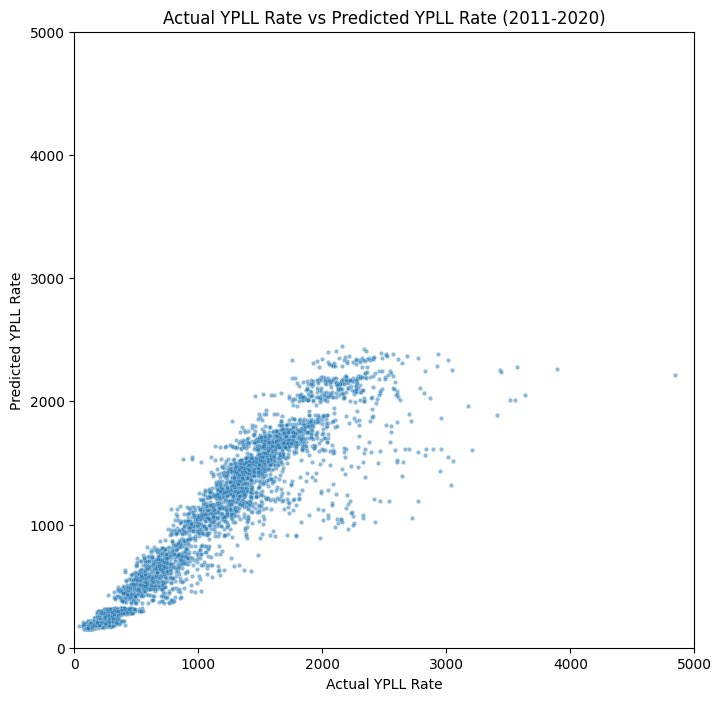

In [437]:
plot_df = pd.DataFrame({"actual": y_test.values,
                        "preds": lgb_preds})
plt.figure(figsize=(8,8))
ax = sns.scatterplot(data=plot_df, x="actual", y="preds", alpha=0.5, s=10)
ax.set_ylim(0, 5000)
ax.set_xlim(0, 5000)
ax.set_title("Actual YPLL Rate vs Predicted YPLL Rate (2011-2020)")
ax.set_xlabel("Actual YPLL Rate")
ax.set_ylabel("Predicted YPLL Rate")
plt.show()

### 2030 Prediction ----------------------

In [328]:
# Creating a template dataframe for 2021-2030 for the model's predictions
template = ypll_df[ypll_df['year'] == 2019].copy()
future_frames = []

for i in range(2021, 2031):
  temp = template.copy()
  temp['year'] = i
  temp['years_from_start'] = i - 1999
  future_frames.append(temp)

future = pd.concat(future_frames, ignore_index=True)
future.drop(columns=["ypll"], inplace=True)

future_model = lgb.LGBMRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    learning_rate=0.01,
    num_leaves=31,
    linear_tree = True
)

future_model.fit(
    ypll_df.drop('ypll', axis=1),
    ypll_df['ypll'],
    categorical_feature=["state", "sex", "UCD"],
)

preds = future_model.predict(future)

future['ypll'] = preds


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 11220, number of used features: 15
[LightGBM] [Info] Start training from score 876.167569


In [329]:
with open('/content/drive/MyDrive/School/CSE 6242/model.pkl', 'wb') as f:
    pickle.dump(future_model, f)

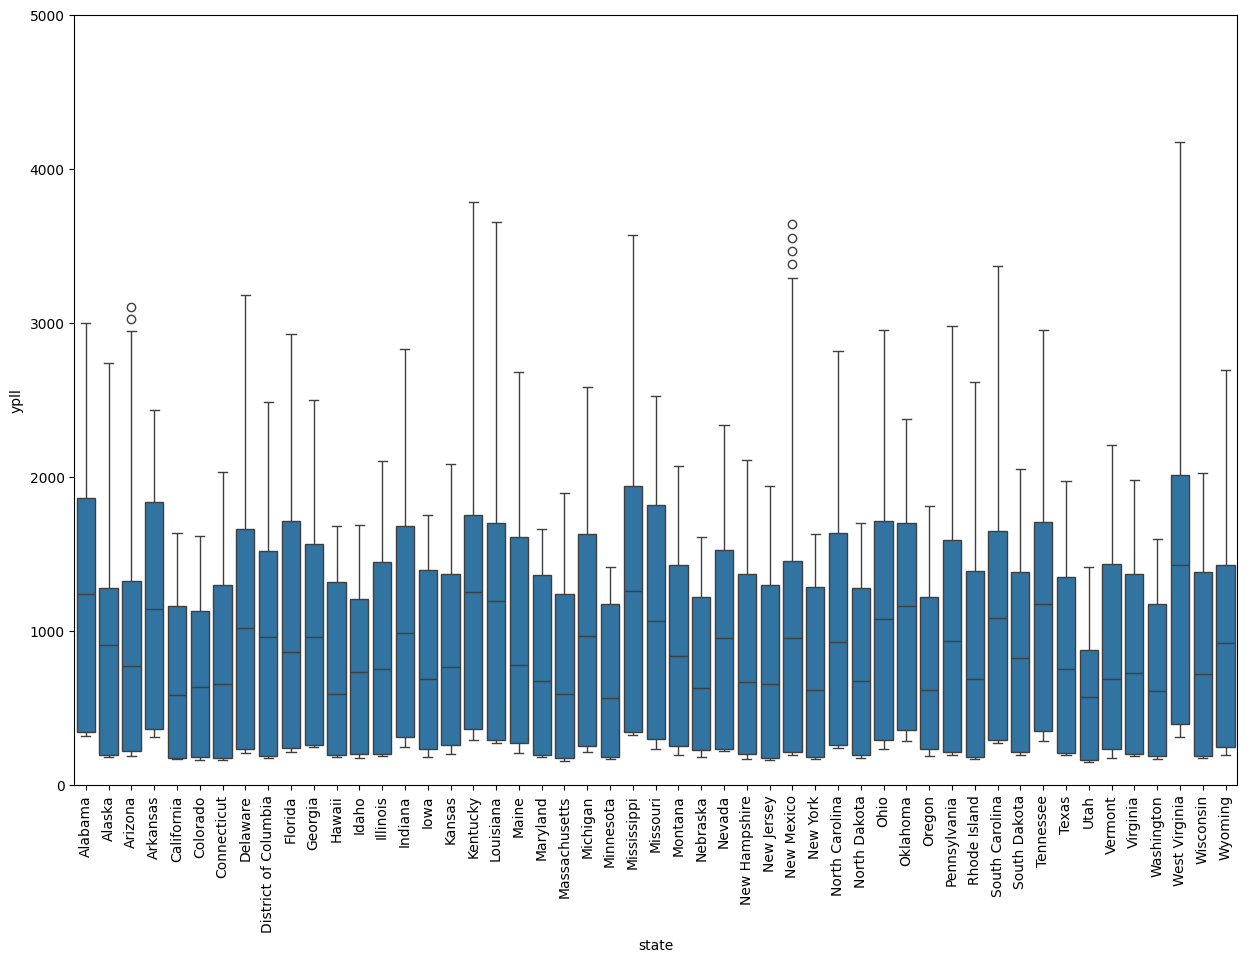

In [443]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=future, x="state", y="ypll")
plt.ylim(0, 5000)
plt.xticks(rotation=90)
plt.show()

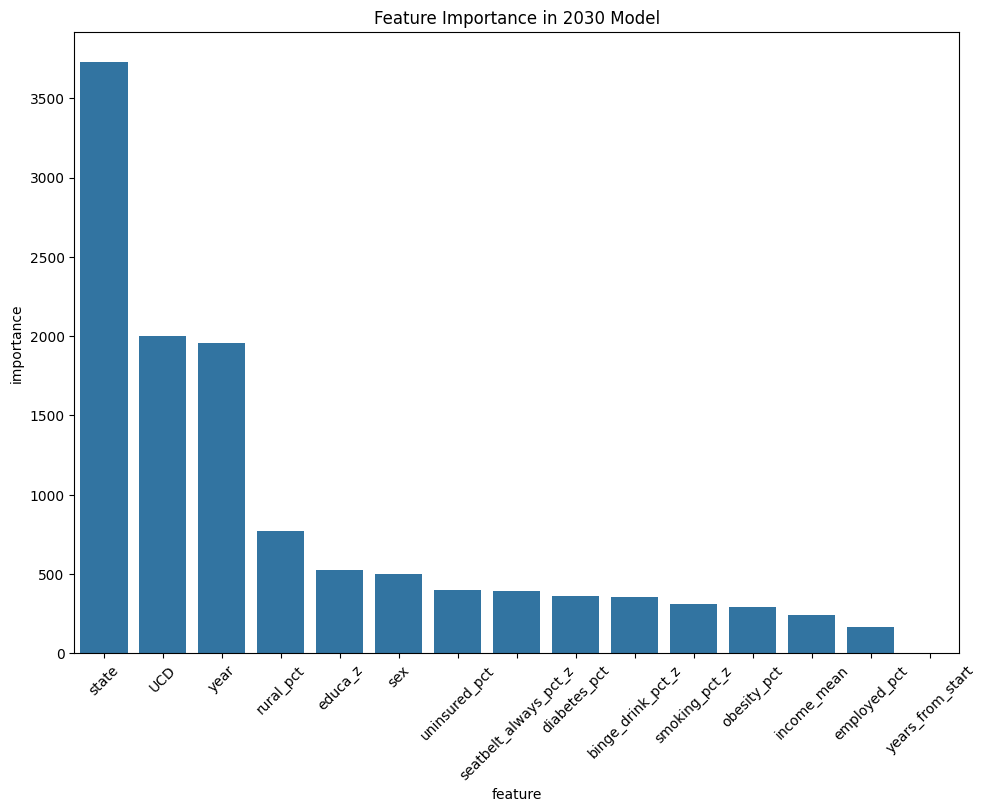

In [451]:
feat_names = future_model.feature_name_
feat_importances = future_model.feature_importances_
feat = pd.DataFrame(data={"feature": feat_names, "importance": feat_importances}).sort_values("importance", ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(data=feat, x='feature', y='importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("Feature Importance in 2030 Model")
plt.show()

<Figure size 1500x1000 with 0 Axes>

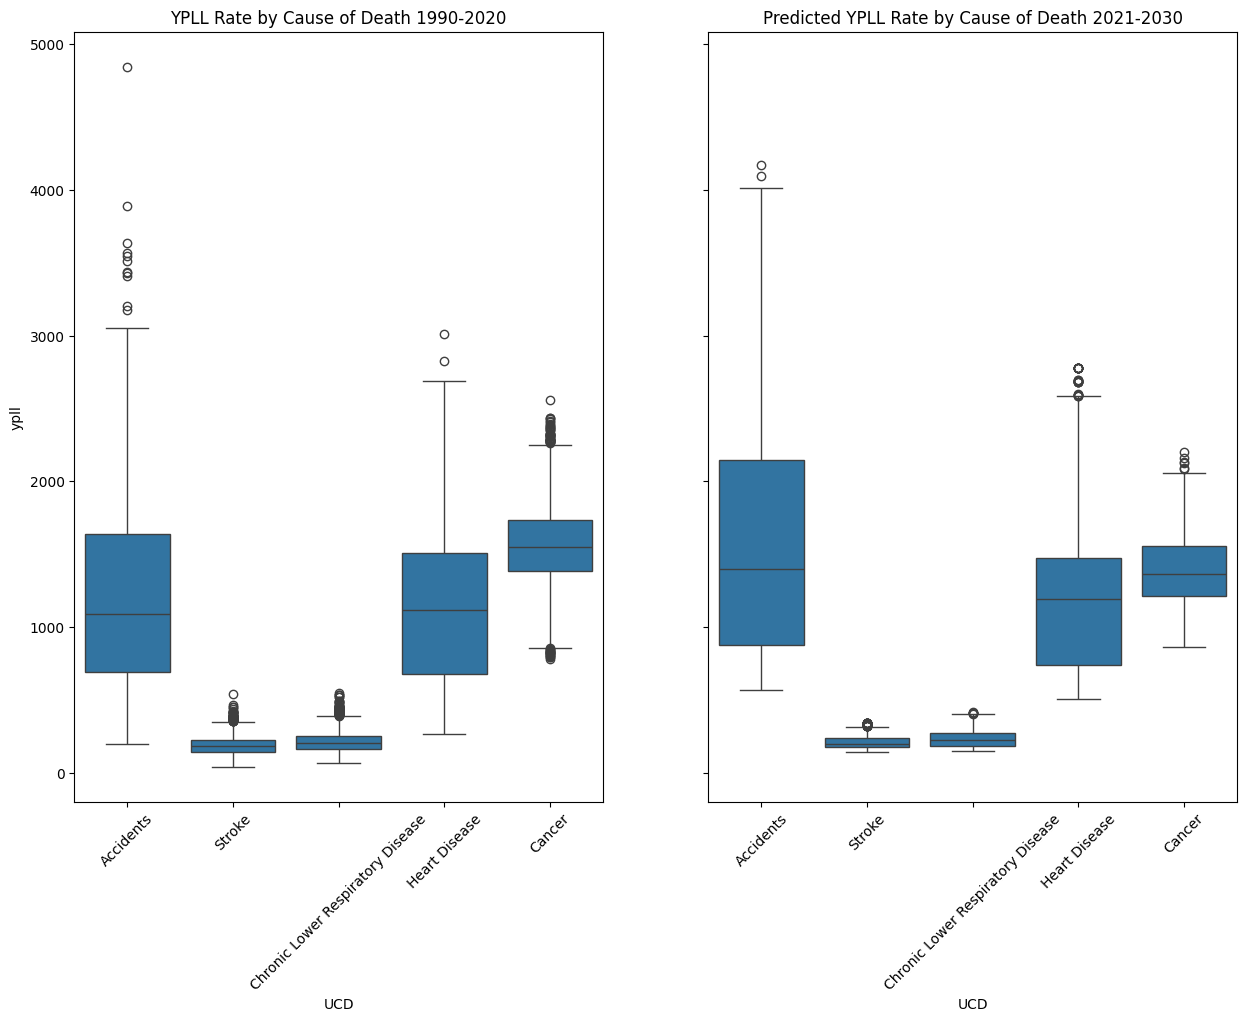

In [462]:
plt.figure(figsize=(15, 10))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), sharey = True, sharex = True)

sns.boxplot(data=ypll_df, x="UCD", y="ypll", ax=ax1)
sns.boxplot(data=future, x="UCD", y="ypll", ax=ax2)
ax1.set_title('YPLL Rate by Cause of Death 1990-2020')
ax2.set_title('Predicted YPLL Rate by Cause of Death 2021-2030')
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
plt.show()